In [13]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import TomekLinks, RandomUnderSampler, CondensedNearestNeighbour, OneSidedSelection

from imblearn.pipeline import Pipeline

# 모델
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# 모델 평가 
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve, 
                             auc, precision_recall_curve, accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix)

from sklearn.model_selection import learning_curve

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import pyreadstat

from matplotlib import rc
%matplotlib inline
rc('font', family='Arial Unicode MS')

from IPython.display import Image

#### 함수들

In [2]:
# preprocessed
def getFirstData(outlierCol=None):

    data = pd.read_csv('../CVD_cleaned.csv')

    if outlierCol != None:
        # outlier 제거
        # outlier를 제거할 column
        selected_columns = outlierCol

        # IQR 계산
        Q1 = data[selected_columns].quantile(0.25)
        Q3 = data[selected_columns].quantile(0.75)
        IQR = Q3 - Q1

        # weight
        threshold = 1.5

        outlier_mask = (
            (data[selected_columns] < (Q1 - threshold * IQR)) |
            (data[selected_columns] > (Q3 + threshold * IQR))
        ).any(axis=1)

        # outlier 제거
        data_nooutlier = data[~outlier_mask]
        data = data_nooutlier



    # 성별 원핫인코딩
    data = pd.get_dummies(data, columns=['Sex'])
    sex_columns = ['Sex_Female', 'Sex_Male']
    for column in sex_columns:
        data[column] = data[column].map({True: 1, False: 0})

    # Yes, No -> 1, 0
    binary_columns = ['Heart_Disease', 'Skin_Cancer', 'Other_Cancer', 
                    'Depression', 'Arthritis', 'Smoking_History','Exercise']

    # diabetes
    diabetes_mapping = {
        'No': 0,
        'No, pre-diabetes or borderline diabetes': 0, 
        'Yes, but female told only during pregnancy': 1,
        'Yes': 1
    }
    data['Diabetes'] = data['Diabetes'].map(diabetes_mapping)

    # Heart_Disease, Skin_Cancer, Other_Cancer, Depression, Arthritis, Smoking_History, Exercise
    for column in binary_columns:
        data[column] = data[column].map({'Yes': 1, 'No': 0})

    # General_Health, Checkup, Age_Category
    general_health_mapping = {
        'Poor': 0,
        'Fair': 1,
        'Good': 2,
        'Very Good': 3,
        'Excellent': 4
    }

    data['General_Health'] = data['General_Health'].map(general_health_mapping)

    checkup_mapping = {
        'Never': 0,
        '5 or more years ago': 1,
        'Within the past 5 years': 2,
        'Within the past 2 years': 3,
        'Within the past year': 4
        
    }
    data['Checkup'] = data['Checkup'].map(checkup_mapping)

    # {'18-29', '30-39', '40-49', '50-59', '60-69', '75-79', '80+'}
    age_category_mapping = {
        '18-24': 0,
        '25-29': 1,
        '30-34': 2,
        '35-39': 3,
        '40-44': 4,
        '45-49': 5,
        '50-54': 6,
        '55-59': 7,
        '60-64': 8,
        '65-69': 9,
        '70-74': 10,
        '75-79': 11,
        '80+': 12
    }
    data['Age_Category'] = data['Age_Category'].map(age_category_mapping)  

    return data


# age category 변경
def getSecData():
    data = pd.read_csv('../CVD_cleaned.csv')

    # age category 변경
    data.loc[(data['Age_Category']=='18-24') | (data['Age_Category']=='25-29'), 'Age_Category'] = '18-29'
    data.loc[(data['Age_Category']=='30-34') | (data['Age_Category']=='35-39'), 'Age_Category'] = '30-39'
    data.loc[(data['Age_Category']=='40-44') | (data['Age_Category']=='45-49'), 'Age_Category'] = '40-49'
    data.loc[(data['Age_Category']=='50-54') | (data['Age_Category']=='55-59'), 'Age_Category'] = '50-59'
    data.loc[(data['Age_Category']=='60-64') | (data['Age_Category']=='65-69'), 'Age_Category'] = '60-69'
    data.loc[(data['Age_Category']=='70-74') | (data['Age_Category']=='75-79'), 'Age_Category'] = '70-79'



    # 성별 원핫인코딩
    data = pd.get_dummies(data, columns=['Sex'])
    sex_columns = ['Sex_Female', 'Sex_Male']
    for column in sex_columns:
        data[column] = data[column].map({True: 1, False: 0})

    # Yes, No -> 1, 0
    binary_columns = ['Heart_Disease', 'Skin_Cancer', 'Other_Cancer', 
                    'Depression', 'Arthritis', 'Smoking_History','Exercise']

    # diabetes
    diabetes_mapping = {
        'No': 0,
        'No, pre-diabetes or borderline diabetes': 0, 
        'Yes, but female told only during pregnancy': 1,
        'Yes': 1
    }
    data['Diabetes'] = data['Diabetes'].map(diabetes_mapping)

    # Heart_Disease, Skin_Cancer, Other_Cancer, Depression, Arthritis, Smoking_History, Exercise
    for column in binary_columns:
        data[column] = data[column].map({'Yes': 1, 'No': 0})

    # General_Health, Checkup, Age_Category
    general_health_mapping = {
        'Poor': 0,
        'Fair': 1,
        'Good': 2,
        'Very Good': 3,
        'Excellent': 4
    }

    data['General_Health'] = data['General_Health'].map(general_health_mapping)

    checkup_mapping = {
        'Never': 0,
        '5 or more years ago': 1,
        'Within the past 5 years': 2,
        'Within the past 2 years': 3,
        'Within the past year': 4
        
    }
    data['Checkup'] = data['Checkup'].map(checkup_mapping)

    # {'18-29', '30-39', '40-49', '50-59', '60-69', '75-79', '80+'}
    age_category_mapping = {
        '18-29': 0,
        '30-39': 1,
        '40-49': 2,
        '50-59': 3,
        '60-69': 4,
        '70-79': 5,
        '80+': 6
    }
    data['Age_Category'] = data['Age_Category'].map(age_category_mapping)   

    return data


def getThirData():
    # XPT 파일 경로 지정
    xpt_file_path = '../LLCP2021.XPT'

    # XPT 파일 읽어오기
    df, meta = pyreadstat.read_xport(xpt_file_path)

    cols = ['GENHLTH', 'CHECKUP1', 'EXERANY2', 'CVDSTRK3', 'CHCSCNCR', 
            'CHCOCNCR', 'ADDEPEV3', 'DIABETE4', 'DIFFWALK', 'FRUIT2', 'FVGREEN1', 
            'FRENCHF1', 'VEGETAB2', '_PHYS14D','_MENT14D', '_RFHYPE6', '_RFCHOL3', 
            '_MICHD', '_DRDXAR3', '_SEX','_AGEG5YR', 'HTM4', 'WTKG3', '_BMI5', 
            '_RFBMI5','_RFDRHV7', '_SMOKER3', '_RFSMOK3']

    df = df[cols]

    # 데이터프레임 출력
    #df.head()
    df = df.dropna()

    ##### GENHLTH, general health
    # 1 ~ 5: excellent ~ poor, excellent가 1
    # 7, 9: 모름, 무응답

    genhlthM = {
        1: 4,
        2: 3,
        3: 2,
        4: 1,
        5: 0,
        7: None,
        9: None
    }

    ##### CHECKUP1, checkup
    checkupM = {
        1:4, 2: 3, 3:2, 4:1, 5:None, 8:0, 9:None
    }


    ##### EXERANY2, TOLDHI3, CVDSTRK3, CHCSCNCR, CHCOCNCR, ADDEPEV3, DIFFWALK
    # exercise, cholhigh, stroke, skin cancer, other cancer, depression, 
    # difficulty walking
    map1 = {
        1:1, 2:0, 7:None, 9:None
    }

    ##### DIABETE4
    # diabetes
    map2 = {
        1:1, 2:1, 3:0, 4:0, 7:None, 9:None
    }

    ##### _PHYS14D, _MENT14D
    # health 안 좋은 날
    # 1: zero days not good, 2: 1-13 days not good
    phyMentDays = {
        1:5, 2:3, 3:1, 9:None 
    }


    ##### _RFHYPE6, _RFCHOL3
    # 높은 혈압, 높은 콜레스테롤
    map4 = {
        1:0, 2:1, 9:None
    }

    ##### _MICHD, _DRDXAR3, _SEX
    # heart disease, arthritis, sex
    map5 = {
        1:1, 2:0
    }

    ##### age
    ageM = {
        1:0, 2:1, 3:2, 4:3, 5:4, 6:5, 7:6, 8:7, 9:8, 
        10:9, 11:10, 12:11, 13:12, 14:None
    }

    ##### _RFBMI5, _RFSMOK3
    # obese, current smoker
    map6 = {
        1:0, 2:1
    }

    ##### _SMOKER3
    # smoking status - 매일, 가끔, 금연, 흡연경험 없음, 무응답
    map7 = {
        1:5, 2:5, 3:1, 4:0, 9:None
    }

    ##### _RFDRHV7
    # heavy drinkers
    map8 = {
        1:0, 2:1, 9:None
    }

#        cols = ['GENHLTH', 'CHECKUP1', 'EXERANY2', 'CVDSTRK3', 'CHCSCNCR', 'CHCOCNCR', 
#                'ADDEPEV3', 'DIABETE4', 'DIFFWALK', 'FRUIT2', 'FVGREEN1', 'FRENCHF1', 
#                'VEGETAB2', '_PHYS14D','_MENT14D', '_RFHYPE6', '_RFCHOL3', '_MICHD', 
#                '_DRDXAR3', '_SEX','_AGEG5YR', 'HTM4', 'WTKG3', '_BMI5', '_RFBMI5',
#                '_RFDRHV7', '_SMOKER3', '_RFSMOK3']
    

    adjustCols = ['General_Health', 'Checkup', 'Exercise', 'Stroke', 'Skin_Cancer', 'Other_Cancer', 
              'Depression', 'Diabetes', 'DiffWalk', 'Fruit_Consumption', 'Green_Vegetables_Consumption', 'FriedPotato_Consumption', 
              'OtherVegetables', 'Physical_Health', 'Mental_Health', 'BPHigh', 'CholHigh', 'Heart_Disease', 
              'Arthritis', 'Sex', 'Age_Categories', 'Height_(cm)', 'Weight_(kg)', 'BMI', 'Obese',
              'HeavyDrinker', 'SmokeStatus', 'CurrentSmoker']
    
    df2 = df.copy()
    df2.columns = adjustCols

    df2['General_Health'] = df2['General_Health'].map(genhlthM)
    df2['Checkup'] = df2['Checkup'].map(checkupM)
    df2['Exercise'] = df2['Exercise'].map(map1)
    df2['Stroke'] = df2['Stroke'].map(map1)
    df2['Skin_Cancer'] = df2['Skin_Cancer'].map(map1)
    df2['Other_Cancer'] = df2['Other_Cancer'].map(map1)
    df2['Depression'] = df2['Depression'].map(map1)
    df2['Diabetes'] = df2['Diabetes'].map(map2)
    df2['DiffWalk'] = df2['DiffWalk'].map(map1)
    df2['Physical_Health'] = df2['Physical_Health'].map(phyMentDays)
    df2['Mental_Health'] = df2['Mental_Health'].map(phyMentDays)
    df2['BPHigh'] = df2['BPHigh'].map(map4)
    df2['CholHigh'] = df2['CholHigh'].map(map4)
    df2['Heart_Disease'] = df2['Heart_Disease'].map(map5)
    df2['Arthritis'] = df2['Arthritis'].map(map5)
    df2['Sex'] = df2['Sex'].map(map5)
    df2['Age_Categories'] = df2['Age_Categories'].map(ageM)
    df2['Obese'] = df2['Obese'].map(map6)
    df2['HeavyDrinker'] = df2['HeavyDrinker'].map(map8)
    df2['SmokeStatus'] = df2['SmokeStatus'].map(map7)
    df2['CurrentSmoker'] = df2['CurrentSmoker'].map(map6)


    df2['Weight_(kg)'] = df2['Weight_(kg)']/100
    df2['BMI'] = df2['BMI']/100


    # 'Fruit_Consumption', 'Green_Vegetables_Consumption',
    #   'FriedPotato_Consumption', 'OtherVegetables'

    df2['Fruit_Consumption'] = pd.cut(df2['Fruit_Consumption'], bins=[0, 200, 300, 301, 400, 600, 1000], right=False, labels=[30, 5, 1, 0.5, 0, -1])
    df2['Fruit_Consumption'].astype(float)
    df2['Green_Vegetables_Consumption'] = pd.cut(df2['Green_Vegetables_Consumption'], bins=[0, 200, 300, 301, 400, 600, 1000], right=False, labels=[30, 5, 1, 0.5, 0, -1])
    df2['Green_Vegetables_Consumption'].astype(float)
    df2['FriedPotato_Consumption'] = pd.cut(df2['FriedPotato_Consumption'], bins=[0, 200, 300, 301, 400, 600, 1000], right=False, labels=[30, 5, 1, 0.5, 0, -1])
    df2['FriedPotato_Consumption'].astype(float)
    df2['OtherVegetables'] = pd.cut(df2['OtherVegetables'], bins=[0, 200, 300, 301, 400, 600, 1000], right=False, labels=[30, 5, 1, 0.5, 0, -1])
    df2['OtherVegetables'].astype(float)

    df2['Fruit_Consumption'] = df2['Fruit_Consumption'].map({30:30, 5:5, 1:1, 0.5:0.5, 0:0, -1:None})
    df2['Green_Vegetables_Consumption'] = df2['Green_Vegetables_Consumption'].map({30:30, 5:5, 1:1, 0.5:0.5, 0:0, -1:None})
    df2['FriedPotato_Consumption'] = df2['FriedPotato_Consumption'].map({30:30, 5:5, 1:1, 0.5:0.5, 0:0, -1:None})
    df2['OtherVegetables'] = df2['OtherVegetables'].map({30:30, 5:5, 1:1, 0.5:0.5, 0:0, -1:None})
    
    df2 = df2.dropna()
    return df2

# 모델 train, test scores 각각 반환
def train_test_scores(X, y, test_size=0.2, 
                      model=None,
                      scaler=None,
                      pipe=None):

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=test_size, 
                                                        random_state=13, 
                                                        stratify=y)

    if scaler != None:
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)


    tmp = []

    if model != None:
        if model == 'lr':
            clf = LogisticRegression(random_state=13)

        elif model == 'dt':
            clf = DecisionTreeClassifier(random_state=13)

        elif model == 'rf':
            clf = RandomForestClassifier(random_state=13)

        elif model == 'lgbm':
            clf = LGBMClassifier(random_state=13)

        elif model == 'xgboost':
            clf = XGBClassifier(random_state=13)
        
        name = model

    elif pipe != None:
        clf = pipe

    clf.fit(X_train, y_train)
    pred_train = clf.predict(X_train) # train
    pred = clf.predict(X_test) # test

    acc_train = accuracy_score(y_train, pred_train)
    pre_train = precision_score(y_train, pred_train)
    re_train = recall_score(y_train, pred_train)
    f1_train = f1_score(y_train, pred_train)
    aucc_train = roc_auc_score(y_train, pred_train)

    acc = accuracy_score(y_test, pred)
    pre = precision_score(y_test, pred)
    re = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    aucc = roc_auc_score(y_test, pred)

    # 결과 df로 저장
    tmp.append([f'{name}_clf_train', acc_train, pre_train, re_train, f1_train, aucc_train])
    tmp.append([f'{name}_clf_test', acc, pre, re, f1, aucc])

    col_names = ['model_names', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    df = pd.DataFrame(tmp, columns=col_names)

    return df

# 모든 모델 resample 적용 후 반환
def resample_scores_all(X, y, test_size=0.2, 
                      scaler=None,
                      resample=None):

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=test_size, 
                                                        random_state=13, 
                                                        stratify=y)

    if scaler != None:
        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)


    if resample != None: 
        # resample
        X_train, y_train = resample.fit_resample(X_train, y_train)

    models = [LogisticRegression(random_state=13), DecisionTreeClassifier(random_state=13), 
              RandomForestClassifier(random_state=13), LGBMClassifier(random_state=13), 
              XGBClassifier(random_state=13)]

    tmp = []

    for clf in models:
        clf.fit(X_train, y_train)
        pred_train = clf.predict(X_train) # train
        pred = clf.predict(X_test) # test

        acc_train = accuracy_score(y_train, pred_train)
        pre_train = precision_score(y_train, pred_train)
        re_train = recall_score(y_train, pred_train)
        f1_train = f1_score(y_train, pred_train)
        aucc_train = roc_auc_score(y_train, pred_train)

        acc = accuracy_score(y_test, pred)
        pre = precision_score(y_test, pred)
        re = recall_score(y_test, pred)
        f1 = f1_score(y_test, pred)
        aucc = roc_auc_score(y_test, pred)

        name = str(clf).split('(')[0]

        # 결과 df로 저장
        tmp.append([f'{name}_train', acc_train, pre_train, re_train, f1_train, aucc_train])
        tmp.append([f'{name}_test', acc, pre, re, f1, aucc])
        tmp.append([' ', ' ', ' ', ' ', ' ', ' '])

  

    col_names = ['model_names', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    df = pd.DataFrame(tmp, columns=col_names)

    return df

# Trial 1
- age category 5단위
- outlier 제거 x
- scaling x
- resampling x
- gridsearch x

In [36]:
data = getFirstData() 

X = data.drop("Heart_Disease", axis = 1)
y = data['Heart_Disease']

lr_df = train_test_scores(X, y, model='lr')
dt_df = train_test_scores(X, y, model='dt')
rf_df = train_test_scores(X, y, model='rf')
lgbm_df = train_test_scores(X, y, model='lgbm')
xgboost_df = train_test_scores(X, y, model='xgboost')

display(lr_df)
display(dt_df)
display(rf_df)
display(lgbm_df)
display(xgboost_df)

,model_names,accuracy,precision,recall,f1,roc_auc
0,lr_clf_train,0.919056,0.496068,0.072634,0.126714,0.533072
1,lr_clf_test,0.918862,0.488220,0.074690,0.129559,0.533902


,model_names,accuracy,precision,recall,f1,roc_auc
0,dt_clf_train,0.999984,1.000000,0.999800,0.999900,0.999900
1,dt_clf_test,0.863901,0.206029,0.239487,0.221502,0.579155


,model_names,accuracy,precision,recall,f1,roc_auc
0,rf_clf_train,0.999935,1.000000,0.999199,0.999599,0.999600
1,rf_clf_test,0.918117,0.437008,0.044453,0.080698,0.519708


,model_names,accuracy,precision,recall,f1,roc_auc
0,lgbm_clf_train,0.920266,0.612013,0.037743,0.071102,0.517819
1,lgbm_clf_test,0.919914,0.575563,0.035843,0.067484,0.516759


,model_names,accuracy,precision,recall,f1,roc_auc
0,xgboost_clf_train,0.923248,0.719931,0.082995,0.148833,0.540078
1,xgboost_clf_test,0.918975,0.490018,0.054065,0.097385,0.524558


# Trial 2
- age category 10단위
- outlier 제거 x
- scaling x
- resampling x
- gridsearch x

> 유의미한 차이를 보이지 않음. 

In [37]:
data = getSecData()

X = data.drop("Heart_Disease", axis = 1)
y = data['Heart_Disease']

lr_df = train_test_scores(X, y, model='lr')
dt_df = train_test_scores(X, y, model='dt')
rf_df = train_test_scores(X, y, model='rf')
lgbm_df = train_test_scores(X, y, model='lgbm')
xgboost_df = train_test_scores(X, y, model='xgboost')

display(lr_df)
display(dt_df)
display(rf_df)
display(lgbm_df)
display(xgboost_df)

,model_names,accuracy,precision,recall,f1,roc_auc
0,lr_clf_train,0.918926,0.489484,0.064074,0.113314,0.529098
1,lr_clf_test,0.919363,0.510078,0.065879,0.116687,0.530157


,model_names,accuracy,precision,recall,f1,roc_auc
0,dt_clf_train,0.999972,1.000000,0.999650,0.999825,0.999825
1,dt_clf_test,0.862605,0.200686,0.234481,0.216271,0.576168


,model_names,accuracy,precision,recall,f1,roc_auc
0,rf_clf_train,0.999935,0.999950,0.999249,0.999599,0.999622
1,rf_clf_test,0.918651,0.469548,0.047857,0.086862,0.521551


,model_names,accuracy,precision,recall,f1,roc_auc
0,lgbm_clf_train,0.920302,0.620865,0.036642,0.069200,0.517337
1,lgbm_clf_test,0.919639,0.548077,0.034241,0.064455,0.515879


,model_names,accuracy,precision,recall,f1,roc_auc
0,xgboost_clf_train,0.923414,0.727547,0.084347,0.151169,0.540784
1,xgboost_clf_test,0.919234,0.504638,0.054465,0.098319,0.524881


# Trial 3
- age category 5단위
- bmi outlier 제거 o
- scaling x
- resampling x
- gridsearch x

>유의미한 차이를 보이지 않음.

In [38]:
data = getFirstData(['BMI'])

X = data.drop("Heart_Disease", axis = 1)
y = data['Heart_Disease']

lr_df = train_test_scores(X, y, model='lr')
dt_df = train_test_scores(X, y, model='dt')
rf_df = train_test_scores(X, y, model='rf')
lgbm_df = train_test_scores(X, y, model='lgbm')
xgboost_df = train_test_scores(X, y, model='xgboost')

display(lr_df)
display(dt_df)
display(rf_df)
display(lgbm_df)
display(xgboost_df)

,model_names,accuracy,precision,recall,f1,roc_auc
0,lr_clf_train,0.919727,0.505239,0.045114,0.082832,0.520627
1,lr_clf_test,0.920037,0.527187,0.046362,0.085228,0.521365


,model_names,accuracy,precision,recall,f1,roc_auc
0,dt_clf_train,0.999987,1.000000,0.999844,0.999922,0.999922
1,dt_clf_test,0.862240,0.193399,0.225364,0.208161,0.571623


,model_names,accuracy,precision,recall,f1,roc_auc
0,rf_clf_train,0.999958,1.000000,0.999480,0.999740,0.999740
1,rf_clf_test,0.919051,0.459459,0.042412,0.077655,0.519026


,model_names,accuracy,precision,recall,f1,roc_auc
0,lgbm_clf_train,0.920863,0.629464,0.036642,0.069253,0.517379
1,lgbm_clf_test,0.920421,0.587121,0.032225,0.061096,0.515122


,model_names,accuracy,precision,recall,f1,roc_auc
0,xgboost_clf_train,0.923736,0.719874,0.083212,0.14918,0.540192
1,xgboost_clf_test,0.919001,0.462136,0.049480,0.08939,0.522224


# Trial 4
- age category 5단위
- bmi outlier 제거 x
- scaling o: StandardScaler()
- resampling x
- gridsearch x

>유의미한 차이를 보이지 않음. 아주 약간 좋아짐. 

In [39]:
data = getFirstData()

X = data.drop("Heart_Disease", axis = 1)
y = data['Heart_Disease']

lr_df = train_test_scores(X, y, model='lr', scaler=StandardScaler())
dt_df = train_test_scores(X, y, model='dt', scaler=StandardScaler())
rf_df = train_test_scores(X, y, model='rf', scaler=StandardScaler())
lgbm_df = train_test_scores(X, y, model='lgbm', scaler=StandardScaler())
xgboost_df = train_test_scores(X, y, model='xgboost', scaler=StandardScaler())

display(lr_df)
display(dt_df)
display(rf_df)
display(lgbm_df)
display(xgboost_df)

,model_names,accuracy,precision,recall,f1,roc_auc
0,lr_clf_train,0.919306,0.508048,0.061621,0.109911,0.528186
1,lr_clf_test,0.919234,0.503975,0.063476,0.112751,0.528990


,model_names,accuracy,precision,recall,f1,roc_auc
0,dt_clf_train,0.999984,1.000000,0.999800,0.999900,0.999900
1,dt_clf_test,0.864176,0.207443,0.241089,0.223004,0.580035


,model_names,accuracy,precision,recall,f1,roc_auc
0,rf_clf_train,0.999939,1.000000,0.999249,0.999624,0.999625
1,rf_clf_test,0.918295,0.448141,0.045855,0.083197,0.520444


,model_names,accuracy,precision,recall,f1,roc_auc
0,lgbm_clf_train,0.920270,0.616289,0.036742,0.06935,0.517365
1,lgbm_clf_test,0.919979,0.584158,0.035443,0.06683,0.516612


,model_names,accuracy,precision,recall,f1,roc_auc
0,xgboost_clf_train,0.923248,0.719931,0.082995,0.148833,0.540078
1,xgboost_clf_test,0.918975,0.490018,0.054065,0.097385,0.524558


# Trial 5
- age category 5단위
- bmi outlier 제거 x
- scaling o: MinMaxScaler()
- resampling x
- gridsearch x
>유의미한 차이를 보이지 않음.

In [40]:
data = getFirstData()

X = data.drop("Heart_Disease", axis = 1)
y = data['Heart_Disease']

lr_df = train_test_scores(X, y, model='lr', scaler=MinMaxScaler())
dt_df = train_test_scores(X, y, model='dt', scaler=MinMaxScaler())
rf_df = train_test_scores(X, y, model='rf', scaler=MinMaxScaler())
lgbm_df = train_test_scores(X, y, model='lgbm', scaler=MinMaxScaler())
xgboost_df = train_test_scores(X, y, model='xgboost', scaler=MinMaxScaler())

display(lr_df)
display(dt_df)
display(rf_df)
display(lgbm_df)
display(xgboost_df)

,model_names,accuracy,precision,recall,f1,roc_auc
0,lr_clf_train,0.919331,0.509278,0.061821,0.110258,0.528291
1,lr_clf_test,0.919363,0.510467,0.063476,0.112912,0.529061


,model_names,accuracy,precision,recall,f1,roc_auc
0,dt_clf_train,0.999984,1.000000,0.999800,0.999900,0.999900
1,dt_clf_test,0.863771,0.205948,0.239888,0.221626,0.579267


,model_names,accuracy,precision,recall,f1,roc_auc
0,rf_clf_train,0.999939,1.000000,0.999249,0.999624,0.999625
1,rf_clf_test,0.918214,0.442688,0.044854,0.081455,0.519944


,model_names,accuracy,precision,recall,f1,roc_auc
0,lgbm_clf_train,0.920266,0.612013,0.037743,0.071102,0.517819
1,lgbm_clf_test,0.919914,0.575563,0.035843,0.067484,0.516759


,model_names,accuracy,precision,recall,f1,roc_auc
0,xgboost_clf_train,0.923248,0.719931,0.082995,0.148833,0.540078
1,xgboost_clf_test,0.918975,0.490018,0.054065,0.097385,0.524558


# Trial 6
- age category 5단위
- bmi outlier 제거 x
- scaling o: RobustScaler()
- resampling x
- gridsearch x
>유의미한 차이를 보이지 않음.

In [41]:
data = getFirstData()

X = data.drop("Heart_Disease", axis = 1)
y = data['Heart_Disease']

lr_df = train_test_scores(X, y, model='lr', scaler=RobustScaler())
dt_df = train_test_scores(X, y, model='dt', scaler=RobustScaler())
rf_df = train_test_scores(X, y, model='rf', scaler=RobustScaler())
lgbm_df = train_test_scores(X, y, model='lgbm', scaler=RobustScaler())
xgboost_df = train_test_scores(X, y, model='xgboost', scaler=RobustScaler())

display(lr_df)
display(dt_df)
display(rf_df)
display(lgbm_df)
display(xgboost_df)

,model_names,accuracy,precision,recall,f1,roc_auc
0,lr_clf_train,0.919306,0.508055,0.061571,0.109831,0.528163
1,lr_clf_test,0.919234,0.503975,0.063476,0.112751,0.528990


,model_names,accuracy,precision,recall,f1,roc_auc
0,dt_clf_train,0.999984,1.000000,0.999800,0.999900,0.999900
1,dt_clf_test,0.864079,0.206116,0.238887,0.221295,0.578978


,model_names,accuracy,precision,recall,f1,roc_auc
0,rf_clf_train,0.999935,1.000000,0.999199,0.999599,0.999600
1,rf_clf_test,0.918214,0.443137,0.045254,0.082122,0.520126


,model_names,accuracy,precision,recall,f1,roc_auc
0,lgbm_clf_train,0.920274,0.614498,0.037343,0.070407,0.517641
1,lgbm_clf_test,0.920027,0.590000,0.035443,0.066868,0.516638


,model_names,accuracy,precision,recall,f1,roc_auc
0,xgboost_clf_train,0.923248,0.719931,0.082995,0.148833,0.540078
1,xgboost_clf_test,0.918975,0.490018,0.054065,0.097385,0.524558


# Trial 7
- age category 5단위
- bmi outlier 제거 x
- scaling x
- resampling o: SMOTE
- gridsearch x
>성능 좋아짐. 

In [42]:
data = getFirstData()

X = data.drop("Heart_Disease", axis = 1)
y = data['Heart_Disease']

df = resample_scores_all(X, y, resample=SMOTE(random_state=13))

df

,model_names,accuracy,precision,recall,f1,roc_auc
0,LogisticRegression_train,0.821169,0.813695,0.833082,0.823275,0.821169
1,LogisticRegression_test,0.787619,0.201484,0.549059,0.294791,0.67883
2,,,,,,
3,DecisionTreeClassifier_train,0.999987,0.999987,0.999987,0.999987,0.999987
4,DecisionTreeClassifier_test,0.833919,0.182334,0.302563,0.227543,0.591609
5,,,,,,
6,RandomForestClassifier_train,0.999978,0.999978,0.999978,0.999978,0.999978
7,RandomForestClassifier_test,0.886953,0.267041,0.228274,0.246141,0.586582
8,,,,,,
9,LGBMClassifier_train,0.938434,0.969458,0.905392,0.93633,0.938434


# Trial 8
- age category 5단위
- bmi outlier 제거 x
- scaling o: StandardScaler()
- resampling o: SMOTE
- gridsearch x
>- logistic regression의 recall 높아졌다. 
>   - 이전에 했던 것과 다르게 scaler 적용 후 smote 적용했더니 recall 이 조금 더 높아졌다. 
>    
>    - 하지만 다른 oversampling 기법(svmsmote등)에는 시간이 너무 오래 걸려서 적용해보지 못했다. 한 번 돌리는 데 세 시간이 넘게 걸렸다. 
>- random forest의 precision=0.38

In [43]:
data = getFirstData()

X = data.drop("Heart_Disease", axis = 1)
y = data['Heart_Disease']

df = resample_scores_all(X, y, scaler=StandardScaler(),
                         resample=SMOTE(random_state=13))

df

,model_names,accuracy,precision,recall,f1,roc_auc
0,LogisticRegression_train,0.771699,0.753245,0.808134,0.779725,0.771699
1,LogisticRegression_test,0.739894,0.206551,0.780336,0.326642,0.758337
2,,,,,,
3,DecisionTreeClassifier_train,0.999991,1.0,0.999982,0.999991,0.999991
4,DecisionTreeClassifier_test,0.858315,0.195955,0.242491,0.216753,0.577487
5,,,,,,
6,RandomForestClassifier_train,0.999989,0.999996,0.999982,0.999989,0.999989
7,RandomForestClassifier_test,0.912224,0.385561,0.144373,0.210082,0.562068
8,,,,,,
9,LGBMClassifier_train,0.953815,0.994008,0.913133,0.951856,0.953815


# Trial 9
- age category 5단위
- bmi outlier 제거 x
- scaling o: MinMaxScaler()
- resampling o: SMOTE
- gridsearch x
>scaler 차이 별로 없음

In [44]:
data = getFirstData()

X = data.drop("Heart_Disease", axis = 1)
y = data['Heart_Disease']

df = resample_scores_all(X, y, scaler=MinMaxScaler(),
                         resample=SMOTE(random_state=13))

df

,model_names,accuracy,precision,recall,f1,roc_auc
0,LogisticRegression_train,0.768956,0.751854,0.802907,0.776543,0.768956
1,LogisticRegression_test,0.739765,0.206557,0.780937,0.326702,0.75854
2,,,,,,
3,DecisionTreeClassifier_train,0.999991,1.0,0.999982,0.999991,0.999991
4,DecisionTreeClassifier_test,0.854948,0.197713,0.259712,0.224511,0.583508
5,,,,,,
6,RandomForestClassifier_train,0.999989,1.0,0.999978,0.999989,0.999989
7,RandomForestClassifier_test,0.908711,0.368206,0.180416,0.242172,0.576594
8,,,,,,
9,LGBMClassifier_train,0.953641,0.993287,0.913455,0.9517,0.953641


# Trial 10
- age category 5단위
- bmi outlier 제거 x
- scaling o: RobustScaler()
- resampling o: SMOTE
- gridsearch x
>scaler 차이 별로 없음

In [45]:
data = getFirstData()

X = data.drop("Heart_Disease", axis = 1)
y = data['Heart_Disease']

df = resample_scores_all(X, y, scaler=RobustScaler(),
                         resample=SMOTE(random_state=13))

df

,model_names,accuracy,precision,recall,f1,roc_auc
0,LogisticRegression_train,0.769376,0.750415,0.807235,0.777789,0.769376
1,LogisticRegression_test,0.737336,0.205177,0.782539,0.325111,0.75795
2,,,,,,
3,DecisionTreeClassifier_train,0.999991,1.0,0.999982,0.999991,0.999991
4,DecisionTreeClassifier_test,0.859805,0.203014,0.250901,0.224431,0.582132
5,,,,,,
6,RandomForestClassifier_train,0.999991,0.999996,0.999987,0.999991,0.999991
7,RandomForestClassifier_test,0.913115,0.395635,0.14157,0.208524,0.561274
8,,,,,,
9,LGBMClassifier_train,0.954015,0.994404,0.913168,0.952057,0.954015


# Trial 11 (이전 파일 trial 12)
- age category 10단위
- bmi outlier 제거 x
- scaling x
- resampling o: SMOTE(sampling_strategy='miniority')
- gridsearch x
>logistic regression 값 떨어짐. 
>\
>lgbm, xgb는 매우 낮았던 recall값 좀 올라감

In [46]:
data = getFirstData()

X = data.drop("Heart_Disease", axis = 1)
y = data['Heart_Disease']

df = resample_scores_all(X, y, resample=SMOTE(random_state=13, 
                                              sampling_strategy='minority'))

df

,model_names,accuracy,precision,recall,f1,roc_auc
0,LogisticRegression_train,0.821169,0.813695,0.833082,0.823275,0.821169
1,LogisticRegression_test,0.787619,0.201484,0.549059,0.294791,0.67883
2,,,,,,
3,DecisionTreeClassifier_train,0.999987,0.999987,0.999987,0.999987,0.999987
4,DecisionTreeClassifier_test,0.833919,0.182334,0.302563,0.227543,0.591609
5,,,,,,
6,RandomForestClassifier_train,0.999978,0.999978,0.999978,0.999978,0.999978
7,RandomForestClassifier_test,0.886953,0.267041,0.228274,0.246141,0.586582
8,,,,,,
9,LGBMClassifier_train,0.938434,0.969458,0.905392,0.93633,0.938434


# Trial 12 (이전 파일 trial 14)
- age category 5단위
- bmi outlier 제거 x
- scaling x
- resampling o: ADASYN
- gridsearch x
>유의미한 차이를 보이지 않음. 
>\
>SMOTE보다 좀 별로

In [47]:
data = getFirstData()

X = data.drop("Heart_Disease", axis = 1)
y = data['Heart_Disease']

df = resample_scores_all(X, y, resample=ADASYN(random_state=13))

df

,model_names,accuracy,precision,recall,f1,roc_auc
0,LogisticRegression_train,0.819748,0.813273,0.830486,0.821789,0.819739
1,LogisticRegression_test,0.786906,0.200572,0.547857,0.293641,0.677895
2,,,,,,
3,DecisionTreeClassifier_train,0.999989,0.999996,0.999982,0.999989,0.999989
4,DecisionTreeClassifier_test,0.829192,0.170833,0.288746,0.214663,0.582737
5,,,,,,
6,RandomForestClassifier_train,0.999982,0.999987,0.999978,0.999982,0.999982
7,RandomForestClassifier_test,0.88582,0.260303,0.223869,0.240715,0.583956
8,,,,,,
9,LGBMClassifier_train,0.938958,0.971344,0.904711,0.936844,0.938987


# Trial 13 (이전 파일 trial 15)
- age category 5단위
- bmi outlier 제거 x
- scaling x
- resampling o: BorderlineSMOTE
- gridsearch x
>SMOTE보다 약간 나음

In [48]:
data = getFirstData()

X = data.drop("Heart_Disease", axis = 1)
y = data['Heart_Disease']

df = resample_scores_all(X, y, resample=BorderlineSMOTE(random_state=13))

df

,model_names,accuracy,precision,recall,f1,roc_auc
0,LogisticRegression_train,0.83646,0.824782,0.854438,0.839348,0.83646
1,LogisticRegression_test,0.796571,0.210196,0.54986,0.304131,0.684066
2,,,,,,
3,DecisionTreeClassifier_train,0.999987,0.999987,0.999987,0.999987,0.999987
4,DecisionTreeClassifier_test,0.834145,0.180557,0.297157,0.224627,0.589267
5,,,,,,
6,RandomForestClassifier_train,0.999978,0.999982,0.999974,0.999978,0.999978
7,RandomForestClassifier_test,0.889527,0.270447,0.215859,0.240089,0.582321
8,,,,,,
9,LGBMClassifier_train,0.936959,0.963481,0.908347,0.935102,0.936959


# Trial 14 - svmSMOTE (이전 파일 trial 16)
- age category 5단위
- bmi outlier 제거 x
- scaling x
- resampling o: svmSMOTE
- gridsearch x
>지금까지 시행한 oversampling 방법 중 효과 가장 좋음. 
>\
>lr, lgbm, xgb 좋아짐

In [49]:
data = getFirstData()

X = data.drop("Heart_Disease", axis = 1)
y = data['Heart_Disease']

df = resample_scores_all(X, y, resample=SVMSMOTE(random_state=13))

df

,model_names,accuracy,precision,recall,f1,roc_auc
0,LogisticRegression_train,0.841801,0.834357,0.852932,0.843542,0.841801
1,LogisticRegression_test,0.813667,0.239318,0.598919,0.341985,0.715737
2,,,,,,
3,DecisionTreeClassifier_train,0.999987,0.999991,0.999982,0.999987,0.999987
4,DecisionTreeClassifier_test,0.84245,0.188371,0.286744,0.227374,0.589037
5,,,,,,
6,RandomForestClassifier_train,0.99998,0.999987,0.999974,0.99998,0.99998
7,RandomForestClassifier_test,0.901329,0.30745,0.176011,0.223863,0.570569
8,,,,,,
9,LGBMClassifier_train,0.940301,0.964842,0.913904,0.938682,0.940301


# Trial 15 undersampling
- random undersampler
- 나머지 undersampler는 너무 느렸음 (몇 시간 이상 걸림)

In [50]:
data = getFirstData()

X = data.drop("Heart_Disease", axis = 1)
y = data['Heart_Disease']

df = resample_scores_all(X, y, resample=RandomUnderSampler(random_state=13))

df

,model_names,accuracy,precision,recall,f1,roc_auc
0,LogisticRegression_train,0.758097,0.74243,0.790409,0.765669,0.758097
1,LogisticRegression_test,0.73596,0.204512,0.784141,0.324414,0.757932
2,,,,,,
3,DecisionTreeClassifier_train,1.0,1.0,1.0,1.0,1.0
4,DecisionTreeClassifier_test,0.663839,0.147229,0.658991,0.240685,0.661628
5,,,,,,
6,RandomForestClassifier_train,1.0,1.0,1.0,1.0,1.0
7,RandomForestClassifier_test,0.720613,0.194956,0.784742,0.312321,0.749857
8,,,,,,
9,LGBMClassifier_train,0.778495,0.752737,0.829454,0.789236,0.778495


# Trial 16
- logistic regression, random undersampler, svmsmote
- precision_recall score 그래프 보고 임계점 조정함.

In [52]:
data = getFirstData()

X = data.drop(["Heart_Disease"], axis = 1)
y = data['Heart_Disease']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2, 
                                                        random_state=13, 
                                                        stratify=y)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

over = SVMSMOTE(random_state=13)
under = RandomUnderSampler(random_state=13)

# under 후 over 진행
X_train, y_train = under.fit_resample(X_train, y_train)
X_train, y_train = over.fit_resample(X_train, y_train)

model = LogisticRegression(random_state=13,
                           C=0.001, max_iter=1000)
model.fit(X_train, y_train)

pred = model.predict(X_test)

In [53]:
pred_train = model.predict(X_train)

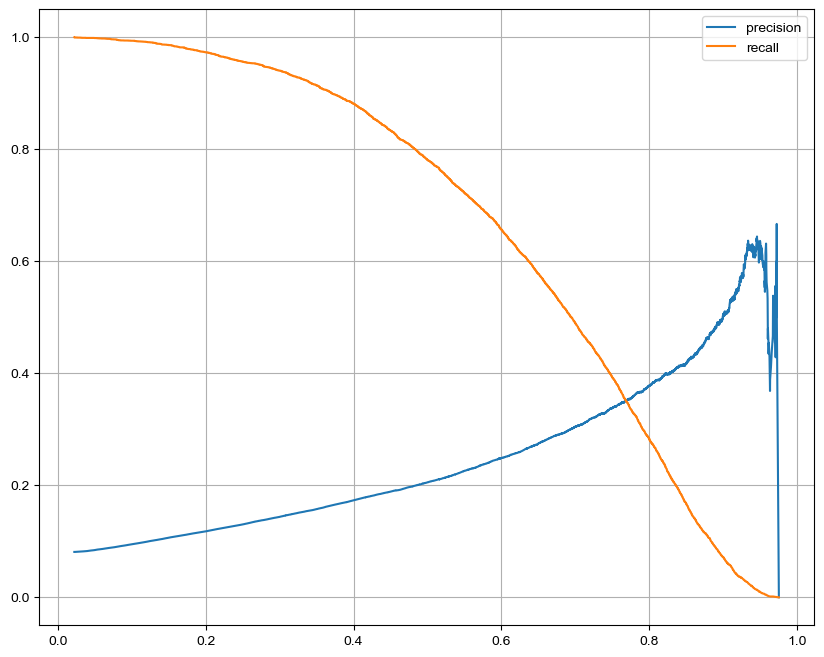

In [54]:
plt.figure(figsize=(10, 8))
predd = model.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, predd)
plt.plot(thresholds, precisions[:len(thresholds)], label='precision')
plt.plot(thresholds, recalls[:len(thresholds)], label='recall')
plt.grid(); plt.legend();plt.show()

In [55]:
thresholdChanged = (predd>=0.73).astype(int)

acc = accuracy_score(y_test, thresholdChanged)
pre = precision_score(y_test, thresholdChanged)
re = recall_score(y_test, thresholdChanged)
f1 = f1_score(y_test, thresholdChanged)
aucc = roc_auc_score(y_test, thresholdChanged)

cols = ['memo', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc']
tmp = []
tmp.append(['lr (under, over, threshold=0.74)', acc, pre, re, f1, aucc])
df = pd.DataFrame(tmp, columns=cols)
df

,memo,accuracy,precision,recall,f1,roc_auc
0,"lr (under, over, threshold=0.74)",0.88098,0.323872,0.434121,0.370979,0.677203


# 원 데이터

## 간단 EDA

In [56]:
data = getThirData()

In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 279062 entries, 0 to 438692
Data columns (total 28 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   General_Health                279062 non-null  float64
 1   Checkup                       279062 non-null  float64
 2   Exercise                      279062 non-null  float64
 3   Stroke                        279062 non-null  float64
 4   Skin_Cancer                   279062 non-null  float64
 5   Other_Cancer                  279062 non-null  float64
 6   Depression                    279062 non-null  float64
 7   Diabetes                      279062 non-null  float64
 8   DiffWalk                      279062 non-null  float64
 9   Fruit_Consumption             279062 non-null  float64
 10  Green_Vegetables_Consumption  279062 non-null  float64
 11  FriedPotato_Consumption       279062 non-null  float64
 12  OtherVegetables               279062 non-null  fl

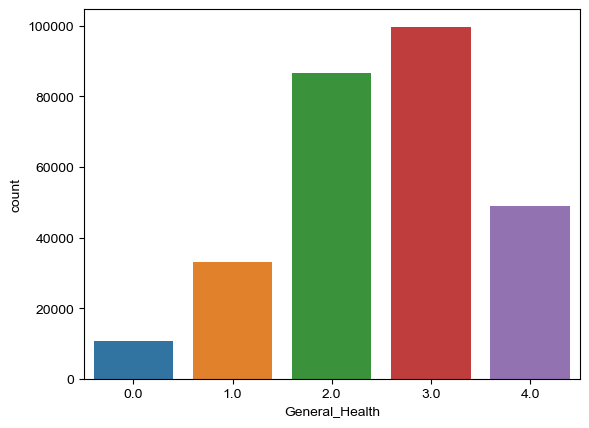

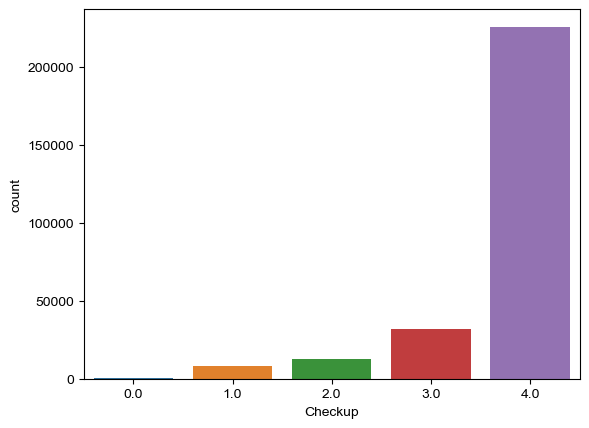

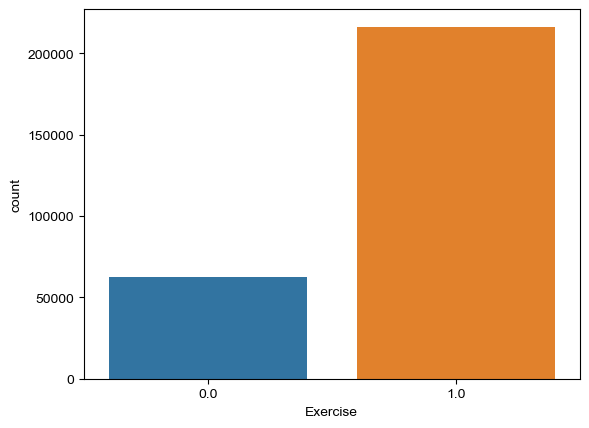

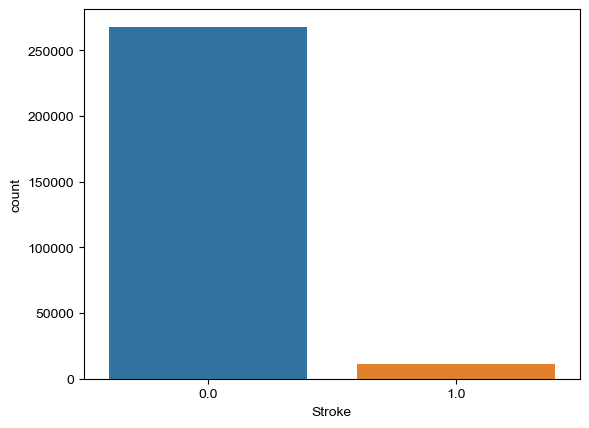

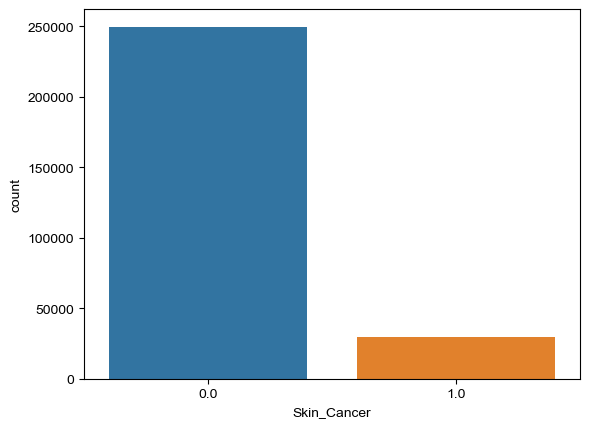

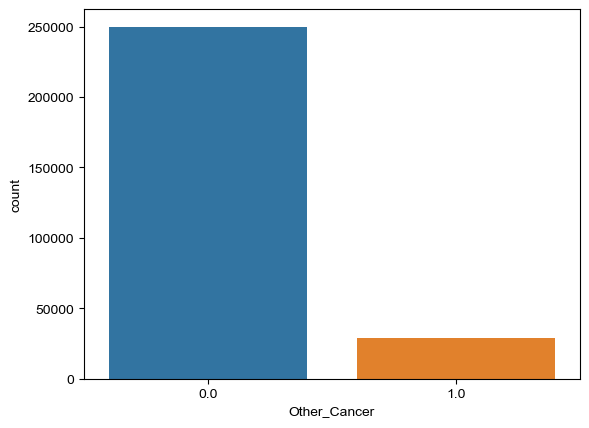

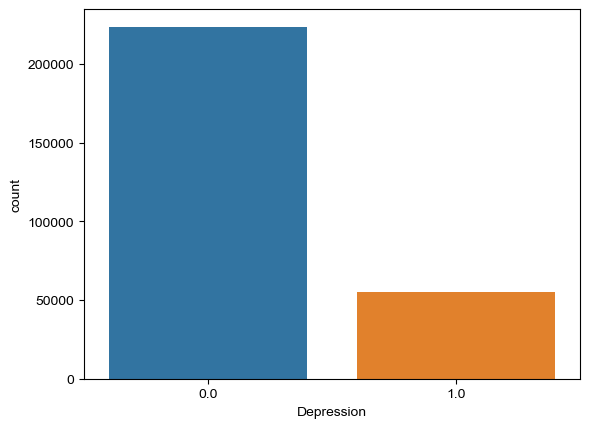

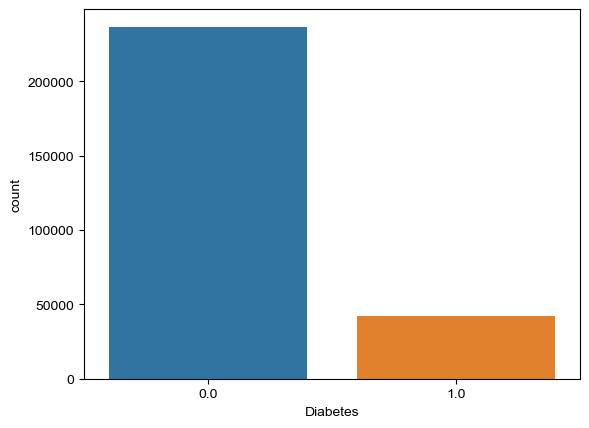

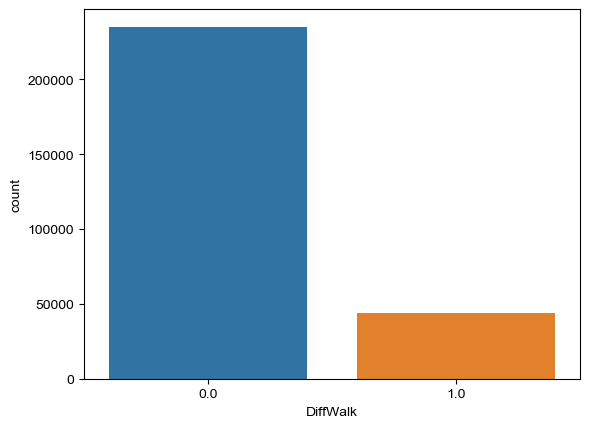

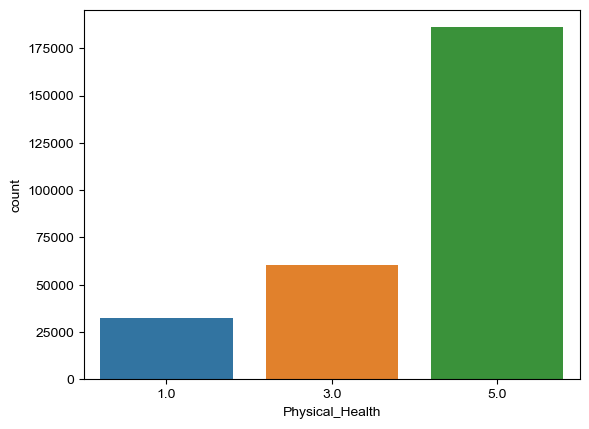

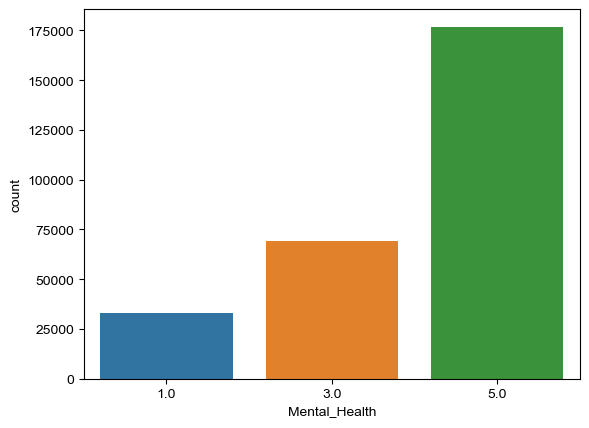

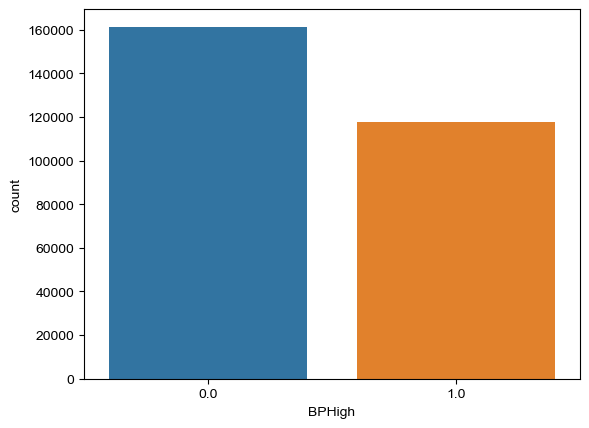

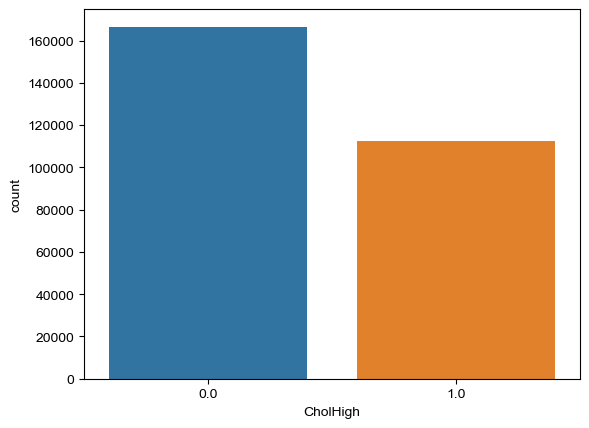

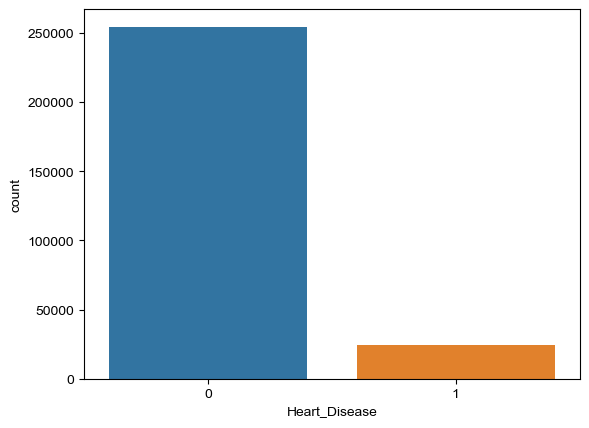

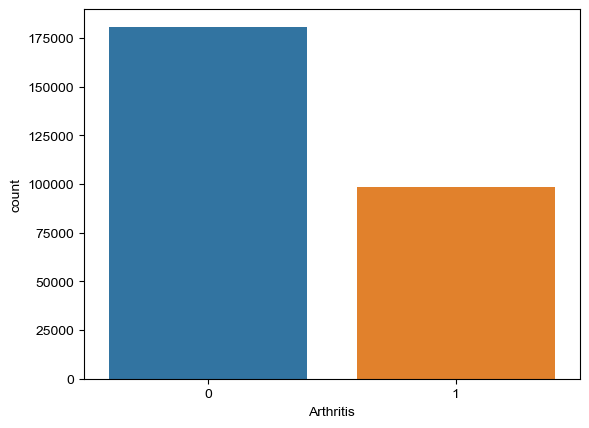

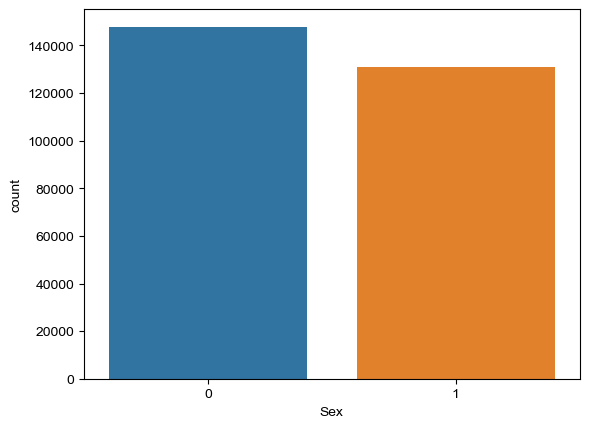

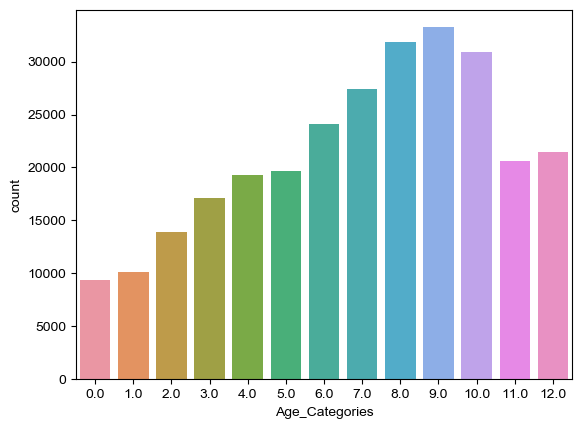

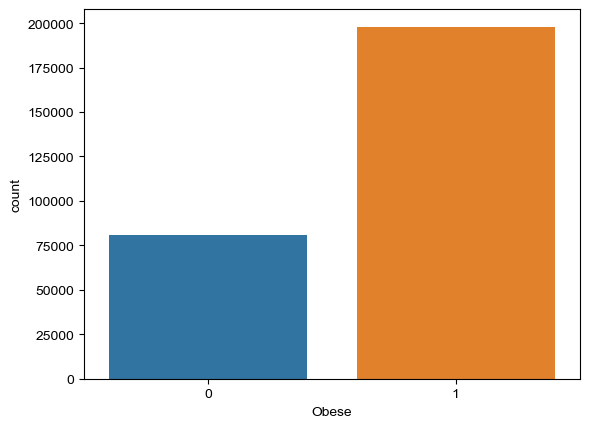

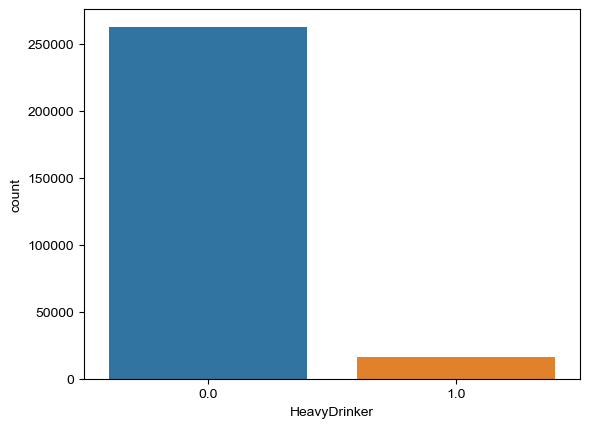

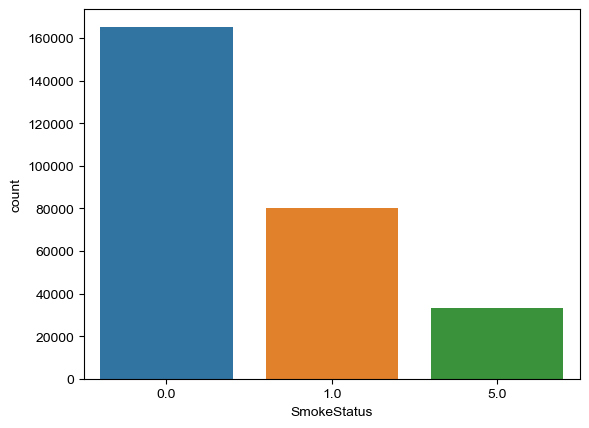

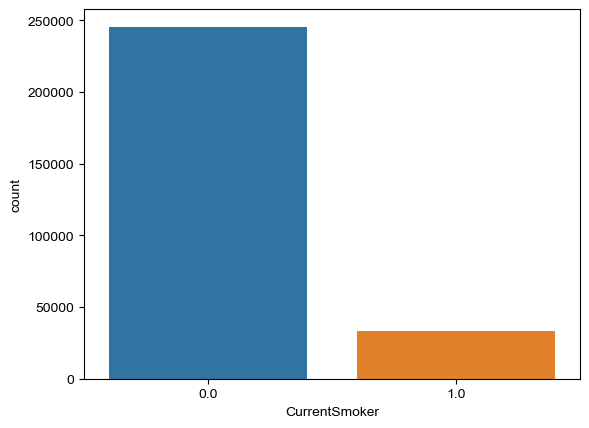

In [8]:
sns.countplot(data=data, x='General_Health')
plt.show()
sns.countplot(data=data, x='Checkup')
plt.show()
sns.countplot(data=data, x='Exercise')
plt.show()
sns.countplot(data=data, x='Stroke')
plt.show()
sns.countplot(data=data, x='Skin_Cancer')
plt.show()
sns.countplot(data=data, x='Other_Cancer')
plt.show()
sns.countplot(data=data, x='Depression')
plt.show()
sns.countplot(data=data, x='Diabetes')
plt.show()
sns.countplot(data=data, x='DiffWalk')
plt.show()
sns.countplot(data=data, x='Physical_Health')
plt.show()
sns.countplot(data=data, x='Mental_Health')
plt.show()
sns.countplot(data=data, x='BPHigh')
plt.show()
sns.countplot(data=data, x='CholHigh')
plt.show()
sns.countplot(data=data, x='Heart_Disease')
plt.show()
sns.countplot(data=data, x='Arthritis')
plt.show()
sns.countplot(data=data, x='Sex')
plt.show()
sns.countplot(data=data, x='Age_Categories')
plt.show()
sns.countplot(data=data, x='Obese')
plt.show()
sns.countplot(data=data, x='HeavyDrinker')
plt.show()
sns.countplot(data=data, x='SmokeStatus')
plt.show()
sns.countplot(data=data, x='CurrentSmoker')
plt.show()

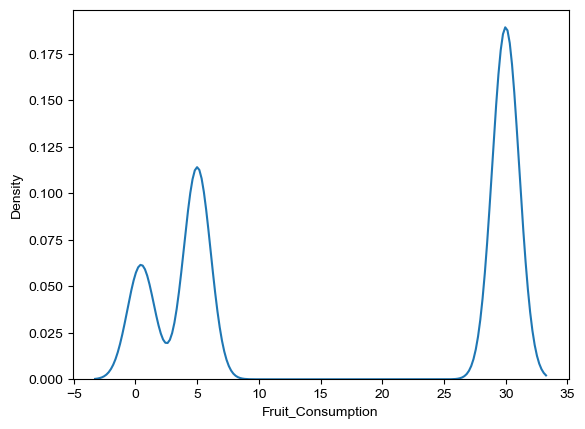

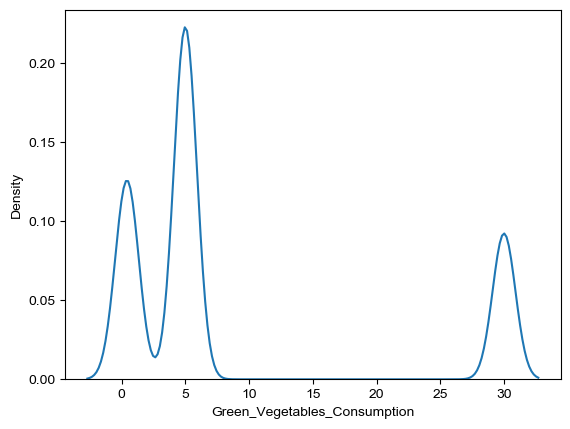

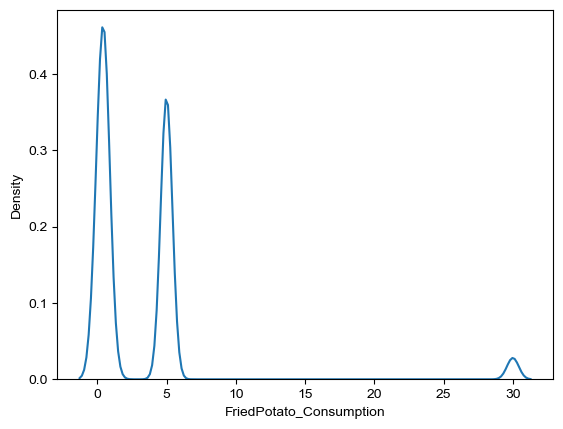

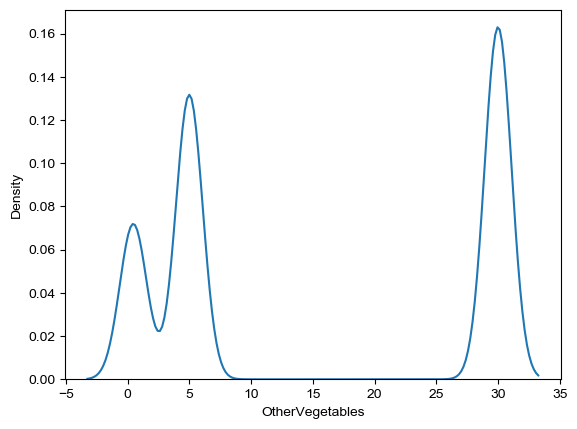

In [9]:
sns.kdeplot(data=data, x='Fruit_Consumption')
plt.show()
sns.kdeplot(data=data, x='Green_Vegetables_Consumption')
plt.show()
sns.kdeplot(data=data, x='FriedPotato_Consumption')
plt.show()
sns.kdeplot(data=data, x='OtherVegetables')
plt.show()

# 원 데이터 - trial 1

In [10]:
data = getThirData() 

X = data.drop("Heart_Disease", axis = 1)
y = data['Heart_Disease']

lr_df = train_test_scores(X, y, model='lr')
dt_df = train_test_scores(X, y, model='dt')
rf_df = train_test_scores(X, y, model='rf')
lgbm_df = train_test_scores(X, y, model='lgbm')
xgboost_df = train_test_scores(X, y, model='xgboost')

display(lr_df)
display(dt_df)
display(rf_df)
display(lgbm_df)
display(xgboost_df)

,model_names,accuracy,precision,recall,f1,roc_auc
0,lr_clf_train,0.913097,0.547260,0.075694,0.132994,0.534824
1,lr_clf_test,0.912529,0.524088,0.073042,0.128214,0.533318


,model_names,accuracy,precision,recall,f1,roc_auc
0,dt_clf_train,0.999924,1.000000,0.999135,0.999567,0.999568
1,dt_clf_test,0.852310,0.217391,0.260427,0.236971,0.584947


,model_names,accuracy,precision,recall,f1,roc_auc
0,rf_clf_train,0.999892,0.999949,0.998830,0.999389,0.999413
1,rf_clf_test,0.911974,0.501404,0.072635,0.126888,0.532830


,model_names,accuracy,precision,recall,f1,roc_auc
0,lgbm_clf_train,0.915211,0.625301,0.092532,0.161209,0.543589
1,lgbm_clf_test,0.912726,0.530220,0.078535,0.136807,0.535908


,model_names,accuracy,precision,recall,f1,roc_auc
0,xgboost_clf_train,0.919637,0.713080,0.146149,0.242580,0.570236
1,xgboost_clf_test,0.911795,0.495951,0.099695,0.166017,0.544955


# 원 데이터 - trial 2
- smote

In [11]:
data = getThirData()

X = data.drop("Heart_Disease", axis = 1)
y = data['Heart_Disease']

df = resample_scores_all(X, y, resample=SMOTE(random_state=13))

df

,model_names,accuracy,precision,recall,f1,roc_auc
0,LogisticRegression_train,0.778885,0.760389,0.814402,0.786469,0.778885
1,LogisticRegression_test,0.73981,0.21629,0.745066,0.335256,0.742184
2,,,,,,
3,DecisionTreeClassifier_train,0.999958,1.0,0.999916,0.999958,0.999958
4,DecisionTreeClassifier_test,0.852436,0.21688,0.2588,0.235993,0.58428
5,,,,,,
6,RandomForestClassifier_train,0.999948,0.99999,0.999907,0.999948,0.999948
7,RandomForestClassifier_test,0.910343,0.443599,0.071211,0.122721,0.531293
8,,,,,,
9,LGBMClassifier_train,0.952282,0.99258,0.911376,0.950247,0.952282


- trial2의 LogisticRegression에서 파라미터를 변경하면서 성능을 확인했다. 
- 최종 모델(3번)의 precision_recall curve

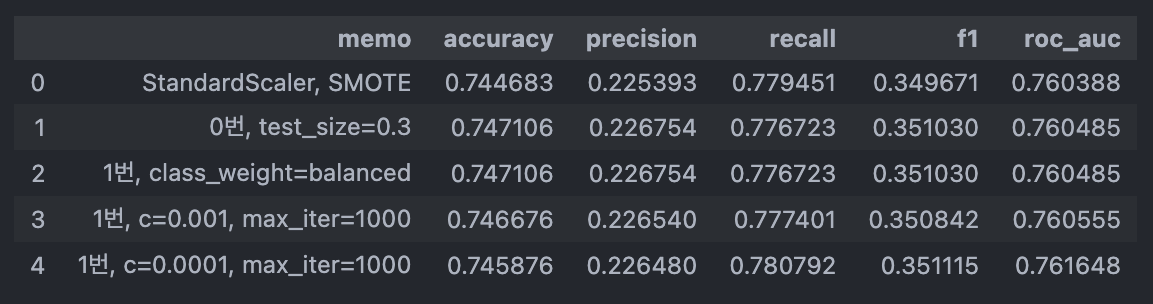

In [17]:
# 파라미터 변경
Image('../images/raw_data_lr.png')

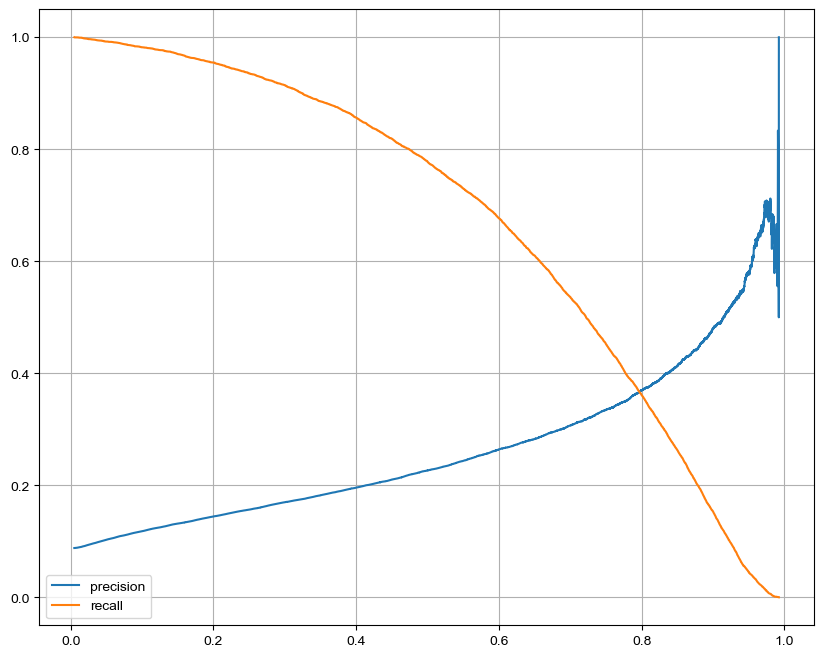

In [18]:
# precision recall curve
Image('../images/lr_output.png')

# 원 데이터 trial 3
- smote, 중복 제거
- 시도했던 모델 중 성능이 그나마 가장 높다. 

In [19]:
tmp2 = []

data = getThirData()
data = data.drop_duplicates()

X = data.drop(["Heart_Disease"], axis = 1)
y = data['Heart_Disease']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.3, 
                                                        random_state=13, 
                                                        stratify=y)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


resample = SMOTE(random_state=13)
X_train, y_train = resample.fit_resample(X_train, y_train)

model = LogisticRegression(random_state=13, C=0.001, max_iter=1000)

model.fit(X_train, y_train)
pred = model.predict(X_test)

acc = accuracy_score(y_test, pred)
pre = precision_score(y_test, pred)
re = recall_score(y_test, pred)
f1 = f1_score(y_test, pred)
aucc = roc_auc_score(y_test, pred)

tmp2.append(['중복제거', acc, pre, re, f1, aucc])

col_names = ['memo', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc']
df2 = pd.DataFrame(tmp2, columns=col_names)

df2

,memo,accuracy,precision,recall,f1,roc_auc
0,중복제거,0.747958,0.229252,0.785404,0.35491,0.764868


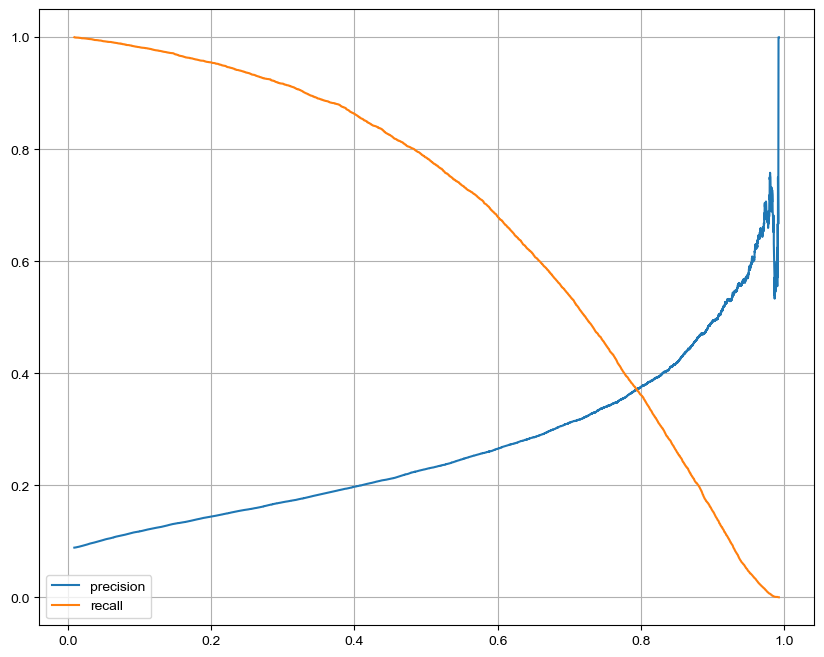

In [20]:
plt.figure(figsize=(10, 8))
predd = model.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, predd)
plt.plot(thresholds, precisions[:len(thresholds)], label='precision')
plt.plot(thresholds, recalls[:len(thresholds)], label='recall')
plt.grid(); plt.legend();plt.show()

precision_recall curve 보면서 threshold 조정하면서 성능 확인. 

In [33]:
thresholdChanged = (predd>=0.75).astype(int)

acc = accuracy_score(y_test, thresholdChanged)
pre = precision_score(y_test, thresholdChanged)
re = recall_score(y_test, thresholdChanged)
f1 = f1_score(y_test, thresholdChanged)
aucc = roc_auc_score(y_test, thresholdChanged)

cols = ['memo', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc']
#tmp2.append(['중복제거 threshold=0.7', acc, pre, re, f1, aucc])
df2 = pd.DataFrame(tmp2, columns=cols)
df2

,memo,accuracy,precision,recall,f1,roc_auc
0,중복제거,0.747958,0.229252,0.785404,0.354910,0.764868
1,중복제거 threshold=0.7,0.854317,0.311764,0.538524,0.394907,0.711709
2,중복제거 threshold=0.8,0.890552,0.375353,0.361096,0.368086,0.651456
3,중복제거 threshold=0.75,0.874135,0.339961,0.452252,0.388148,0.683618
